# Setup and Imports

In [1]:
import sys
if '../Toolkit' not in sys.path: sys.path.append('../Toolkit')

%load_ext autoreload
%autoreload 1

%aimport tools
%aimport models

import tools as t
import models as m

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import clear_output

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 113
import matplotlib.pyplot as plt
import seaborn as sns

RS = 35577 # global random state seed
raw_data_path = 'data-raw'
processed_data_path = 'data-processed'

In [2]:
from pathlib import Path
from sklearn.preprocessing import Normalizer, StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture


# data_csv_path = f'{raw_data_dir_path}/bearing_signals.csv'
# lbls_csv_path = f'{raw_data_dir_path}/bearing_classes.csv'

# Load and select DF

In [3]:
csv_paths = [f for f in Path(f'{raw_data_path}').iterdir()]
csv_paths

[PosixPath('data-raw/audi.csv'),
 PosixPath('data-raw/bmw.csv'),
 PosixPath('data-raw/cclass.csv'),
 PosixPath('data-raw/focus.csv'),
 PosixPath('data-raw/ford.csv'),
 PosixPath('data-raw/hyundi.csv'),
 PosixPath('data-raw/merc.csv'),
 PosixPath('data-raw/skoda.csv'),
 PosixPath('data-raw/toyota.csv'),
 PosixPath('data-raw/unclean cclass.csv'),
 PosixPath('data-raw/unclean focus.csv'),
 PosixPath('data-raw/vauxhall.csv'),
 PosixPath('data-raw/vw.csv')]

In [4]:
all_series = []
for c_p in csv_paths:
    df = pd.read_csv(c_p)
    s = (~df.isna()).sum()
    s.name = c_p.name
    all_series.append(s)
    
df_all_desc = pd.concat(all_series, axis=1).fillna(0)
df_all_desc.style.background_gradient(cmap = 'Greens').format('{:.0f}')

df_all_desc.columns

,audi.csv,bmw.csv,cclass.csv,focus.csv,ford.csv,hyundi.csv,merc.csv,skoda.csv,toyota.csv,unclean cclass.csv,unclean focus.csv,vauxhall.csv,vw.csv
model,10668,10781,3899,5454,17965,4860,13119,6267,6738,3907,5548,13632,15157
year,10668,10781,3899,5454,17965,4860,13119,6267,6738,3904,5459,13632,15157
price,10668,10781,3899,5454,17965,4860,13119,6267,6738,3907,5548,13632,15157
transmission,10668,10781,3899,5454,17965,4860,13119,6267,6738,3907,5548,13632,15157
mileage,10668,10781,3899,5454,17965,4860,13119,6267,6738,3808,4729,13632,15157
fuelType,10668,10781,3899,5454,17965,4860,13119,6267,6738,0,0,13632,15157
tax,10668,10781,0,0,17965,0,13119,6267,6738,0,0,13632,15157
mpg,10668,10781,0,0,17965,4860,13119,6267,6738,0,0,13632,15157
engineSize,10668,10781,3899,5454,17965,4860,13119,6267,6738,0,0,13632,15157
tax(£),0,0,0,0,0,4860,0,0,0,0,0,0,0


Index(['audi.csv', 'bmw.csv', 'cclass.csv', 'focus.csv', 'ford.csv',
       'hyundi.csv', 'merc.csv', 'skoda.csv', 'toyota.csv',
       'unclean cclass.csv', 'unclean focus.csv', 'vauxhall.csv', 'vw.csv'],
      dtype='object')

In [6]:
csv_names = ['audi.csv', 'bmw.csv', 'ford.csv', 'hyundi.csv', 'merc.csv', 'skoda.csv', 'toyota.csv', 'vauxhall.csv', 'vw.csv']

all_dfs = []
for csv_name in csv_names:
    df_path = f'{raw_data_path}/{csv_name}'
    df = pd.read_csv(f'{raw_data_path}/{csv_name}')
    if 'tax(£)' in df.columns:
        df.rename(columns={"tax(£)": "tax"}, inplace=True)
    df.insert(0, 'make', csv_name[:-4].title())
    all_dfs.append(df)
    
df_data = pd.concat(all_dfs, axis=0, ignore_index=True)
df_data.shape
df_data.isna().sum()

df_data

(99187, 10)

make            0
model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Audi,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,Audi,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,Audi,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,Audi,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,Audi,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0
...,...,...,...,...,...,...,...,...,...,...
99182,Vw,Eos,2012,5990,Manual,74000,Diesel,125,58.9,2.0
99183,Vw,Fox,2008,1799,Manual,88102,Petrol,145,46.3,1.2
99184,Vw,Fox,2009,1590,Manual,70000,Petrol,200,42.0,1.4
99185,Vw,Fox,2006,1250,Manual,82704,Petrol,150,46.3,1.2


In [7]:
df_data.duplicated().sum()
df_data.drop_duplicates(inplace=True)
df_data.duplicated().sum()

1475

0

In [8]:
df_data.info()
df_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97712 entries, 0 to 99186
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   make          97712 non-null  object 
 1   model         97712 non-null  object 
 2   year          97712 non-null  int64  
 3   price         97712 non-null  int64  
 4   transmission  97712 non-null  object 
 5   mileage       97712 non-null  int64  
 6   fuelType      97712 non-null  object 
 7   tax           97712 non-null  int64  
 8   mpg           97712 non-null  float64
 9   engineSize    97712 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 8.2+ MB


,year,price,mileage,tax,mpg,engineSize
count,97712.000000,97712.000000,97712.000000,97712.000000,97712.000000,97712.000000
mean,2017.066870,16773.487555,23219.475499,120.142408,55.205623,1.664913
std,2.122993,9868.552222,21060.882301,63.357250,16.181659,0.558574
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,9999.000000,7673.000000,125.000000,47.100000,1.200000
50%,2017.000000,14470.000000,17682.500000,145.000000,54.300000,1.600000
75%,2019.000000,20750.000000,32500.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


In [9]:
df_data.columns

cat_features = ['make', 'model', 'transmission', 'fuelType']
num_features = ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']

len(cat_features + num_features) == len(df.columns)

Index(['make', 'model', 'year', 'price', 'transmission', 'mileage', 'fuelType',
       'tax', 'mpg', 'engineSize'],
      dtype='object')

True

In [10]:
for c in cat_features:
    df_data[c].value_counts()

Ford        17811
Vw          14893
Vauxhall    13258
Merc        12860
Bmw         10664
Audi        10565
Toyota       6699
Skoda        6188
Hyundi       4774
Name: make, dtype: int64

 Fiesta     6509
 Golf       4797
 Focus      4555
 C Class    3694
 Corsa      3285
            ... 
 Ranger        1
200            1
 A2            1
 RS7           1
 Amica         1
Name: model, Length: 195, dtype: int64

Manual       55502
Semi-Auto    22296
Automatic    19905
Other            9
Name: transmission, dtype: int64

Petrol      53982
Diesel      40419
Hybrid       3059
Other         246
Electric        6
Name: fuelType, dtype: int64

In [11]:
df_data[num_features].describe()

,year,price,mileage,tax,mpg,engineSize
count,97712.000000,97712.000000,97712.000000,97712.000000,97712.000000,97712.000000
mean,2017.066870,16773.487555,23219.475499,120.142408,55.205623,1.664913
std,2.122993,9868.552222,21060.882301,63.357250,16.181659,0.558574
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,9999.000000,7673.000000,125.000000,47.100000,1.200000
50%,2017.000000,14470.000000,17682.500000,145.000000,54.300000,1.600000
75%,2019.000000,20750.000000,32500.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


### Remove whitespaces from model

In [12]:
df_data['model'] = df_data['model'].str.strip()

# Visualise the Data

In [13]:
df_data[cat_features]

,make,model,transmission,fuelType
0,Audi,A1,Manual,Petrol
1,Audi,A6,Automatic,Diesel
2,Audi,A1,Manual,Petrol
3,Audi,A4,Automatic,Diesel
4,Audi,A3,Manual,Petrol
...,...,...,...,...
99182,Vw,Eos,Manual,Diesel
99183,Vw,Fox,Manual,Petrol
99184,Vw,Fox,Manual,Petrol
99185,Vw,Fox,Manual,Petrol


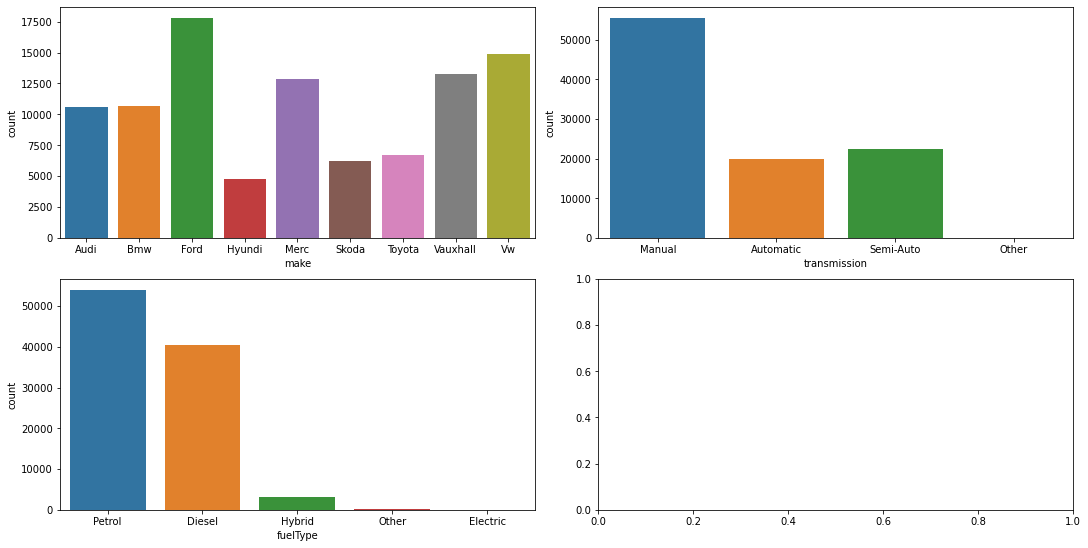

In [14]:
axs = t.get_axes(2, 2, 0.5)
for col, ax in zip(['make', 'transmission', 'fuelType'], axs.flat):
    _ = sns.countplot(ax=ax, data=df_data, x=col)

In [15]:
df_data.loc[df_data['transmission'] =='Other']

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
44153,Hyundi,Ioniq,2017,12495,Other,27779,Hybrid,0,78.5,1.6
44175,Hyundi,Tucson,2017,16995,Other,25915,Petrol,145,39.8,1.6
53924,Merc,GLA Class,2016,18700,Other,30895,Other,125,56.5,0.0
57036,Merc,SLK,2015,12995,Other,39000,Diesel,150,56.5,2.1
63519,Skoda,Scala,2019,15999,Other,3500,Petrol,145,47.1,1.0
66118,Toyota,Yaris,2015,12795,Other,16733,Hybrid,0,78.0,1.5
77102,Vauxhall,Mokka,2019,19995,Other,1450,Diesel,145,57.7,1.5
77717,Vauxhall,Mokka,2019,13499,Other,3000,Petrol,145,44.8,1.4
77820,Vauxhall,Mokka,2019,22499,Other,4500,Petrol,145,42.2,1.5


In [16]:
df_data.loc[df_data['fuelType'] == 'Other'].sort_values(by='tax').head(30)

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
69949,Toyota,Prius,2014,15990,Automatic,23523,Other,0,134.5,1.8
77080,Vauxhall,Viva,2016,5200,Manual,21704,Other,0,65.7,1.0
69899,Toyota,Prius,2011,7250,Manual,112000,Other,0,70.6,1.8
69106,Toyota,Aygo,2017,8000,Automatic,34684,Other,0,67.3,1.0
67299,Toyota,Auris,2016,15495,Automatic,33430,Other,0,76.4,1.8
66539,Toyota,Yaris,2016,10500,Automatic,51102,Other,0,78.0,1.5
66494,Toyota,Yaris,2016,12200,Automatic,10837,Other,0,78.0,1.5
66435,Toyota,Yaris,2016,11690,Automatic,25601,Other,0,86.0,1.5
66417,Toyota,Yaris,2016,12995,Automatic,8059,Other,0,86.0,1.5
66365,Toyota,Yaris,2016,13595,Automatic,15659,Other,0,78.0,1.5


In [17]:
df_data.loc[df_data['fuelType'] == 'Electric']

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
19043,Bmw,i3,2017,18999,Automatic,20321,Electric,135,470.8,0.0
19068,Bmw,i3,2016,18999,Automatic,9990,Electric,0,470.8,0.0
19503,Bmw,i3,2015,17400,Automatic,29465,Electric,0,470.8,1.0
27834,Ford,Mondeo,2016,15975,Automatic,9396,Electric,0,67.3,2.0
33408,Ford,Mondeo,2016,15500,Automatic,24531,Electric,0,67.3,2.0
83715,Vauxhall,Ampera,2015,12999,Automatic,34461,Electric,0,235.4,1.4


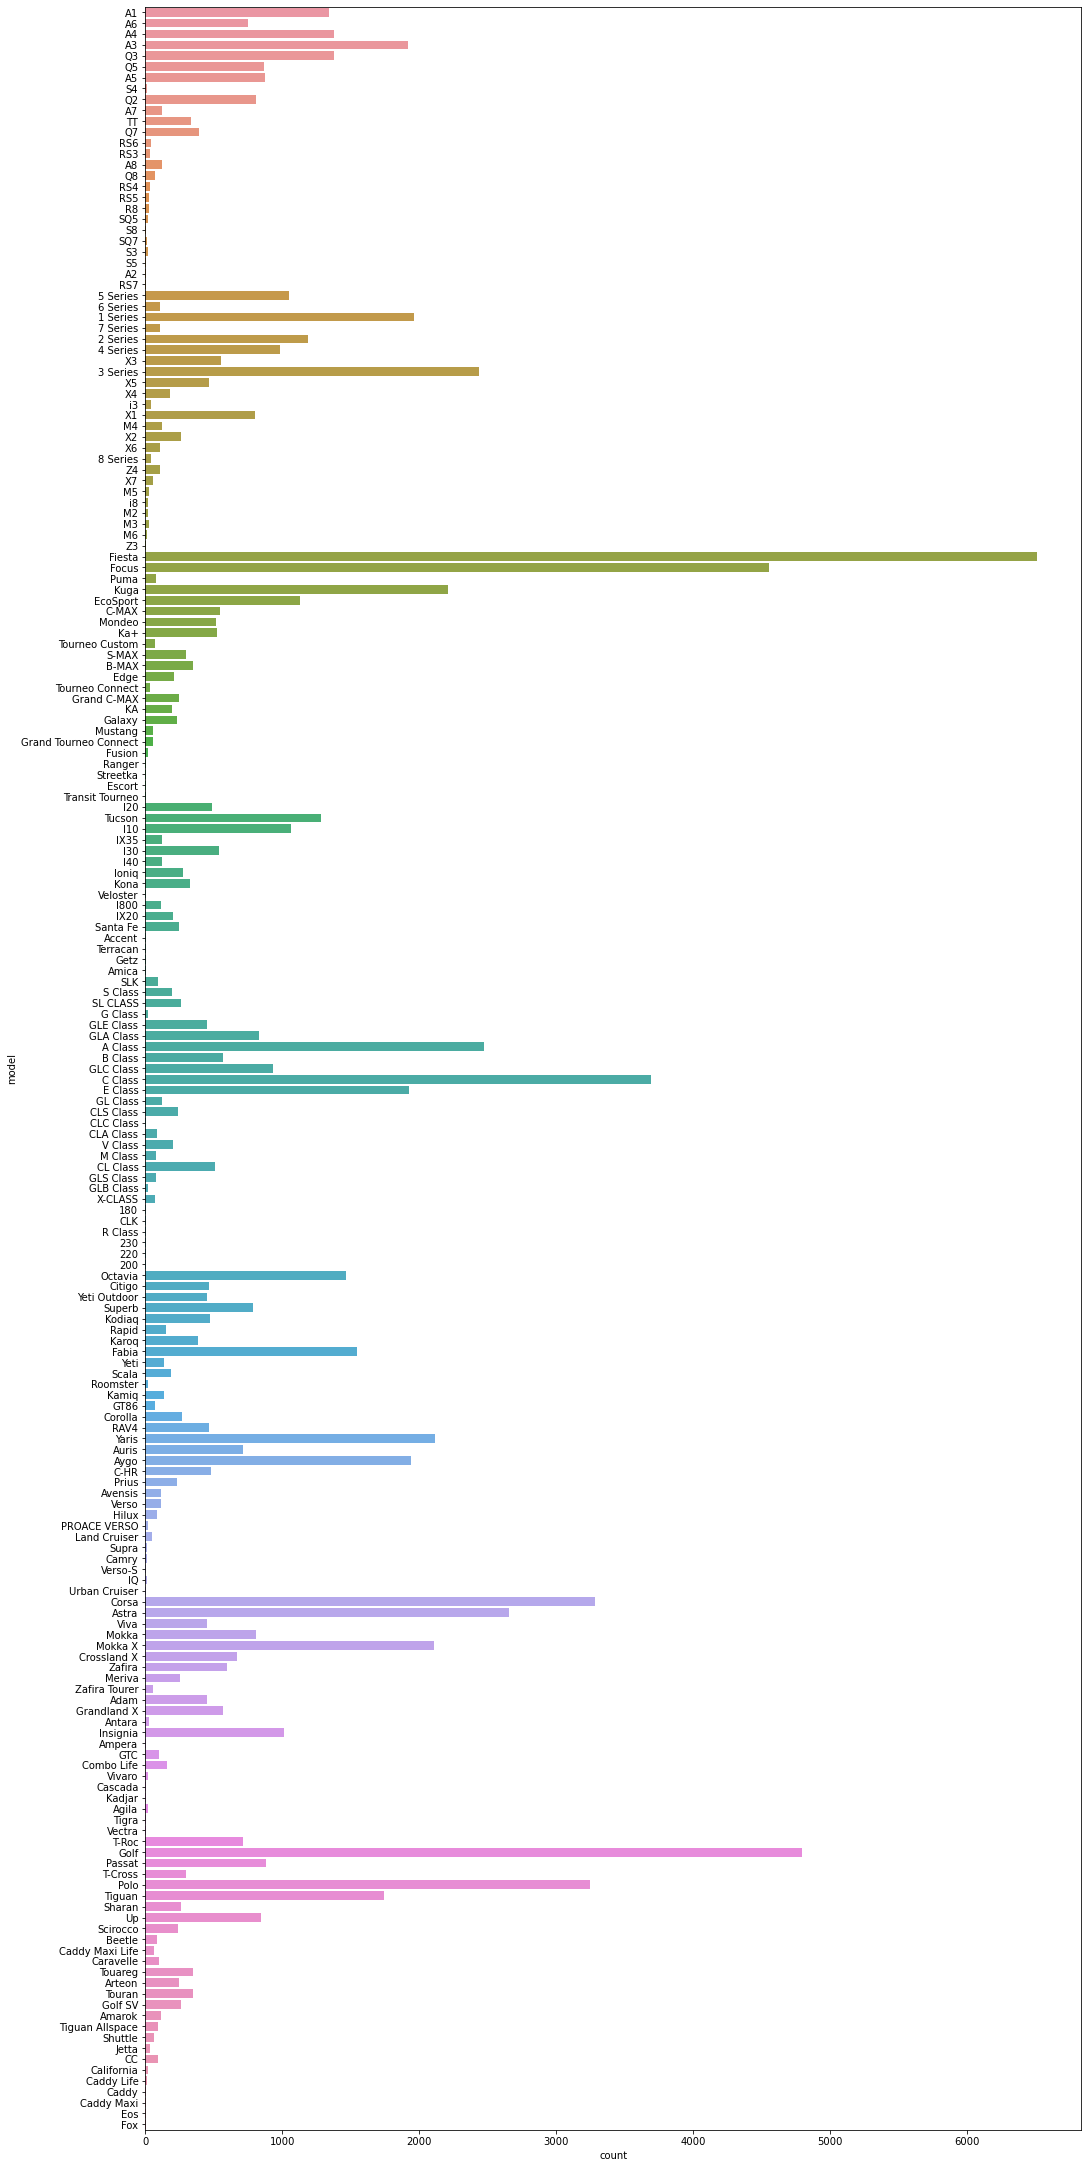

In [18]:
ax = t.get_ax(2)
_ = sns.countplot(ax=ax, data=df_data, y='model')

In [19]:
df_data[num_features]
df_data[num_features].dtypes

,year,price,mileage,tax,mpg,engineSize
0,2017,12500,15735,150,55.4,1.4
1,2016,16500,36203,20,64.2,2.0
2,2016,11000,29946,30,55.4,1.4
3,2017,16800,25952,145,67.3,2.0
4,2019,17300,1998,145,49.6,1.0
...,...,...,...,...,...,...
99182,2012,5990,74000,125,58.9,2.0
99183,2008,1799,88102,145,46.3,1.2
99184,2009,1590,70000,200,42.0,1.4
99185,2006,1250,82704,150,46.3,1.2


year            int64
price           int64
mileage         int64
tax             int64
mpg           float64
engineSize    float64
dtype: object

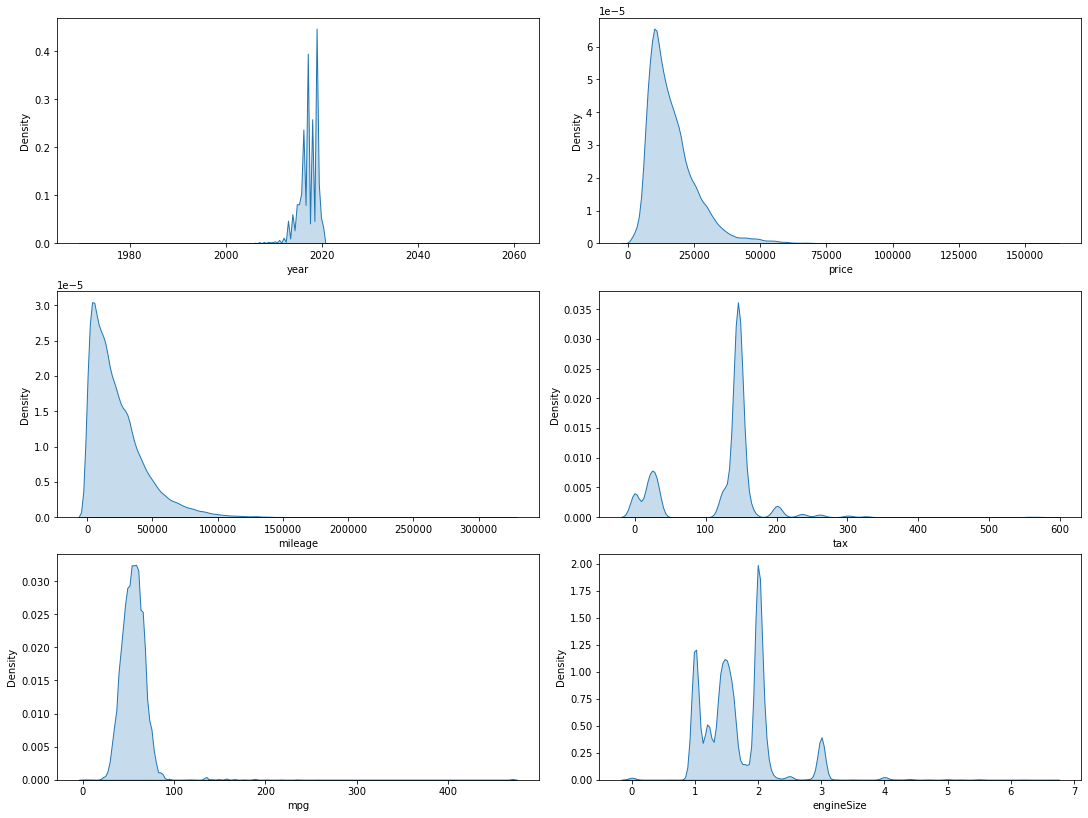

In [20]:
axs = t.get_axes(3, 2, 0.5)

for col, ax in zip(num_features, axs.flat):
    _ = sns.kdeplot(ax=ax, data=df_data, x=col, shade=True)
    # ax.axes.get_yaxis().set_visible(False)

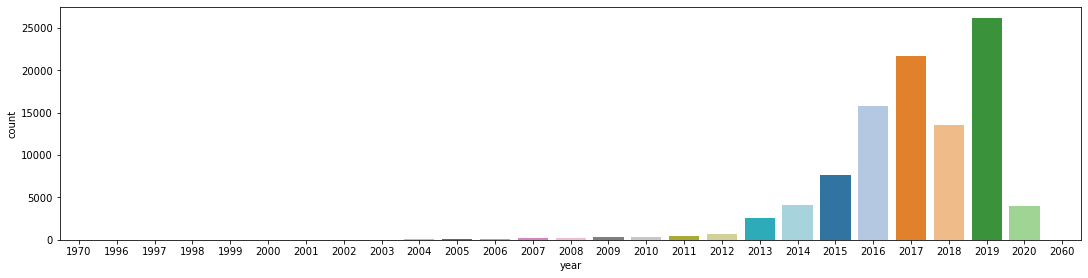

In [21]:
ax = t.get_ax(0.25)
_ = sns.countplot(ax=ax, x = df_data.year, palette=plt.cm.tab20.colors)

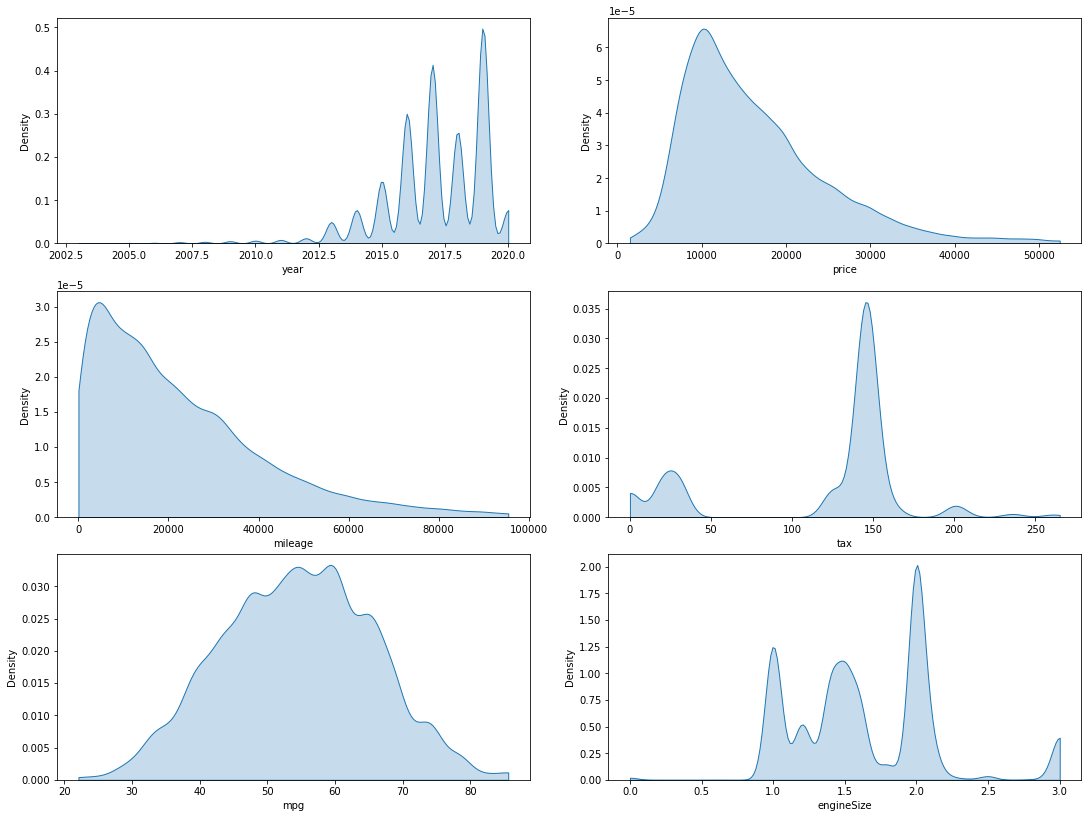

In [22]:
axs = t.get_axes(3, 2, 0.5)

for col, ax in zip(num_features, axs.flat):
    p01 = df_data[col].quantile(0.001)
    p99 = df_data[col].quantile(0.99)
    _ = sns.kdeplot(ax=ax, data=df_data, x=col, shade=True, clip=(p01, p99))
    # ax.axes.get_yaxis().set_visible(False)

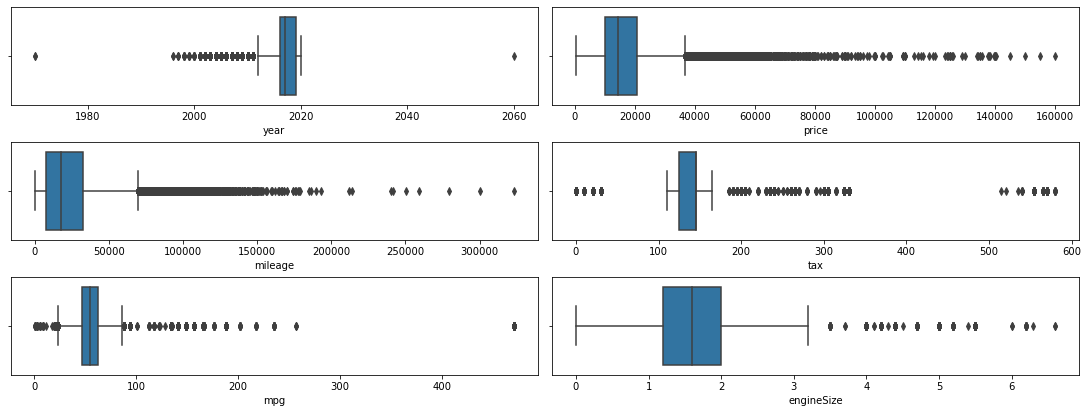

In [23]:
axs = t.get_axes(3, 2, 0.25)

for col, ax in zip(num_features, axs.flat):
    _ = sns.boxplot(ax=ax, x=df_data[col], orient='w')
    # ax.axes.get_yaxis().set_visible(False)

In [24]:
df_data.sort_values(by=['year']).head(5)
df_data.sort_values(by=['year'], ascending=False).head(5)

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
56346,Merc,M Class,1970,24999,Automatic,14000,Diesel,305,39.2,0.0
81235,Vauxhall,Zafira,1970,10495,Manual,37357,Petrol,200,42.2,1.4
20293,Bmw,5 Series,1996,5995,Automatic,36000,Petrol,270,26.4,2.8
38327,Ford,Escort,1996,3000,Manual,50000,Petrol,265,34.4,1.8
10427,Audi,A8,1997,4650,Automatic,122000,Petrol,265,18.9,4.2


,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
39175,Ford,Fiesta,2060,6495,Automatic,54807,Petrol,205,42.8,1.4
91207,Vw,Polo,2020,16489,Manual,3800,Diesel,150,57.7,1.6
3727,Audi,A1,2020,21000,Manual,5000,Petrol,145,47.9,1.0
68633,Toyota,Aygo,2020,10795,Semi-Auto,4569,Petrol,150,56.5,1.0
7612,Audi,Q7,2020,57888,Automatic,1500,Diesel,145,33.2,3.0


In [25]:
df_data.loc[ (1990 < df_data['year']) & (df_data['year'] < 2023)]

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Audi,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,Audi,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,Audi,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,Audi,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,Audi,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0
...,...,...,...,...,...,...,...,...,...,...
99182,Vw,Eos,2012,5990,Manual,74000,Diesel,125,58.9,2.0
99183,Vw,Fox,2008,1799,Manual,88102,Petrol,145,46.3,1.2
99184,Vw,Fox,2009,1590,Manual,70000,Petrol,200,42.0,1.4
99185,Vw,Fox,2006,1250,Manual,82704,Petrol,150,46.3,1.2


In [26]:
df_data.sort_values(by=['price']).head(5)
df_data.sort_values(by=['price'], ascending=False).head(5)

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
84017,Vauxhall,Agila,2003,450,Manual,90000,Petrol,205,43.5,1.2
76318,Vauxhall,Astra,2001,450,Manual,159000,Petrol,235,40.4,1.6
38552,Ford,Focus,2003,495,Manual,177644,Petrol,200,41.5,1.6
73656,Vauxhall,Corsa,2002,495,Manual,99842,Petrol,145,50.4,1.0
73670,Vauxhall,Corsa,2003,590,Manual,82000,Petrol,160,44.8,1.2


,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
50473,Merc,G Class,2020,159999,Semi-Auto,1350,Petrol,145,21.4,4.0
54318,Merc,G Class,2020,154998,Automatic,3000,Petrol,150,21.4,4.0
44279,Merc,SL CLASS,2011,149948,Automatic,3000,Petrol,570,21.4,6.2
4783,Audi,R8,2020,145000,Semi-Auto,2000,Petrol,145,21.1,5.2
53011,Merc,A Class,2019,140319,Semi-Auto,785,Petrol,150,22.1,4.0


In [27]:
df_data.sort_values(by=['mileage']).head(5)
df_data.sort_values(by=['mileage'], ascending=False).head(5)

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
80511,Vauxhall,Crossland X,2019,19995,Manual,1,Petrol,145,47.1,1.2
99017,Vw,Jetta,2014,7985,Manual,1,Diesel,20,67.3,1.6
89276,Vw,Golf,2008,1299,Manual,1,Diesel,145,53.3,1.9
83947,Vauxhall,Combo Life,2019,14634,Manual,1,Diesel,145,53.3,1.5
28379,Ford,Fiesta,2017,10995,Manual,1,Petrol,145,65.7,1.0


,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
9822,Audi,A6,2008,2490,Manual,323000,Diesel,200,44.1,2.0
63462,Skoda,Octavia,2010,1190,Manual,300000,Diesel,125,57.6,1.9
81217,Vauxhall,Zafira,2013,1395,Manual,279000,Diesel,150,55.4,1.7
55618,Merc,V Class,2010,6949,Automatic,259000,Diesel,540,30.7,3.0
62978,Skoda,Octavia,2010,1485,Manual,250650,Diesel,125,57.6,1.9


In [28]:
df_data.sort_values(by=['mpg']).head(5)
df_data.sort_values(by=['mpg'], ascending=False).head(5)

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
98534,Vw,Golf SV,2019,17950,Manual,100,Petrol,145,0.3,1.0
40222,Hyundi,Ioniq,2020,23895,Automatic,4152,Hybrid,135,1.1,1.6
54640,Merc,A Class,2020,33900,Automatic,345,Hybrid,140,1.1,1.3
51244,Merc,A Class,2020,31500,Semi-Auto,1000,Hybrid,135,1.1,1.3
44220,Hyundi,Ioniq,2020,28995,Automatic,5213,Hybrid,135,1.1,1.6


,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
14777,Bmw,i3,2015,17481,Automatic,9886,Hybrid,0,470.8,0.0
10700,Bmw,i3,2016,17100,Automatic,25269,Other,0,470.8,0.6
16413,Bmw,i3,2017,19000,Automatic,23983,Hybrid,0,470.8,0.0
17544,Bmw,i3,2016,14900,Automatic,59945,Hybrid,0,470.8,0.0
20592,Bmw,i3,2016,16500,Automatic,35446,Hybrid,0,470.8,0.0


In [29]:
df_data.loc[df_data['mpg'] > 200].head(10)

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
10700,Bmw,i3,2016,17100,Automatic,25269,Other,0,470.8,0.6
11289,Bmw,i3,2017,19998,Automatic,41949,Hybrid,140,470.8,0.0
11446,Bmw,i3,2017,19998,Automatic,41146,Hybrid,0,470.8,0.0
11448,Bmw,i3,2017,21898,Automatic,10839,Hybrid,0,470.8,0.0
12534,Bmw,i3,2017,19980,Automatic,26965,Hybrid,140,470.8,0.0
13020,Bmw,i3,2016,19490,Automatic,8421,Hybrid,0,470.8,0.0
13945,Bmw,i3,2016,16482,Automatic,43695,Hybrid,0,470.8,0.0
14296,Bmw,i3,2015,14285,Automatic,65800,Hybrid,0,470.8,0.0
14581,Bmw,i3,2017,18500,Automatic,36429,Hybrid,0,470.8,0.0
14768,Bmw,i3,2017,19495,Automatic,17338,Hybrid,135,470.8,0.0


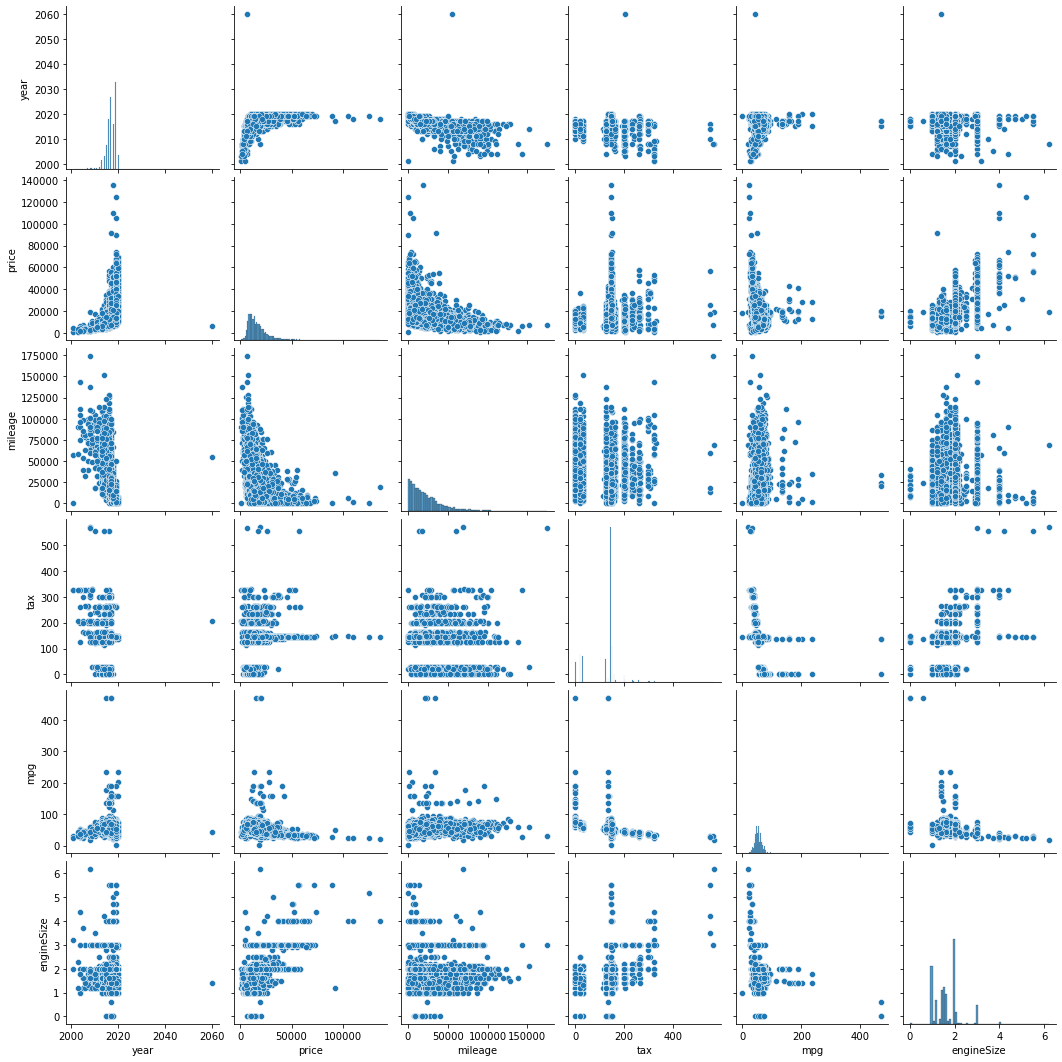

In [30]:
df_plt = df_data.sample(5000, random_state=RS)
_ = sns.pairplot(data=df_plt).fig.set_size_inches(15,15)

## Remove cars that have less than 10 adverts

In [106]:
df_car_adv = df_data.groupby(df_data['make'] + '__' + df_data['model']).size().sort_values()
df_car_adv.head(20)

df_car_adv.value_counts().sort_index().head(20)

Merc__220                1
Audi__A2                 1
Merc__180                1
Ford__Transit Tourneo    1
Hyundi__Accent           1
Hyundi__Amica            1
Ford__Escort             1
Merc__200                1
Ford__Ranger             1
Merc__230                1
Audi__RS7                1
Ford__Streetka           2
Merc__R Class            2
Hyundi__Terracan         2
Merc__CLC Class          3
Vauxhall__Kadjar         3
Vauxhall__Tigra          3
Hyundi__Veloster         3
Toyota__Verso-S          3
Audi__S5                 3
dtype: int64

1     11
2      3
3      7
4      6
6      2
7      3
8      4
11     1
12     2
15     3
16     2
17     2
18     2
21     2
22     1
26     1
27     1
28     2
29     1
31     1
dtype: int64

In [108]:
df_car_10_or_less_adv = df_car_adv.loc[df_car_adv <=10 ]
df_car_10_or_less_adv
'cars to remove', df_car_10_or_less_adv.sum()

Merc__220                1
Audi__A2                 1
Merc__180                1
Ford__Transit Tourneo    1
Hyundi__Accent           1
Hyundi__Amica            1
Ford__Escort             1
Merc__200                1
Ford__Ranger             1
Merc__230                1
Audi__RS7                1
Ford__Streetka           2
Merc__R Class            2
Hyundi__Terracan         2
Merc__CLC Class          3
Vauxhall__Kadjar         3
Vauxhall__Tigra          3
Hyundi__Veloster         3
Toyota__Verso-S          3
Audi__S5                 3
Vauxhall__Ampera         3
Vw__Fox                  4
Toyota__Urban Cruiser    4
Audi__S8                 4
Vauxhall__Cascada        4
Vauxhall__Vectra         4
Vw__Caddy Maxi           4
Hyundi__Getz             6
Vw__Caddy                6
Bmw__Z3                  7
Merc__CLK                7
Vw__Eos                  7
Toyota__IQ               8
Bmw__M6                  8
Vw__Caddy Life           8
Audi__SQ7                8
dtype: int64

('cars to remove', 127)

In [111]:
idx_car_10_or_less_adv = df_data.loc[ (df_data['make'] + '__' + df_data['model']).isin(df_car_10_or_less_adv.index)].index

# Cleaningvalue_counts

In [ ]:
# df_clean = df_data
#     .drop(columns=['mpg', 'tax'])\    
#     .drop(df_data.loc[df_data['transmission'] =='Other'].index, axis=0, errors='ignore')\
#     .drop(df_data.loc[df_data['fuelType'] == 'Other'].index, axis=0, errors='ignore')\
#     .drop(df_data.loc[df_data['fuelType'] == 'Electric'].index, axis=0, errors='ignore')\
#     .drop(df_data.loc[df_data['fuelType'] == 'Electric'].index, axis=0, errors='ignore')\
#     .drop(idx_car_10_or_less_adv, errors='ignore')\
#     .drop(df_data.loc[ (df_data['year'] < 1990) | (2023 < df_data['year']) ].index, axis=0, errors='ignore')\
#     .copy().reset_index(drop=True)

In [112]:
df_data.shape
df_data.head()

(97712, 10)

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Audi,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,Audi,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,Audi,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,Audi,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,Audi,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


- invalid
- not needed
- outliers

In [142]:
df_car_10_or_less_adv

Merc__220                1
Audi__A2                 1
Merc__180                1
Ford__Transit Tourneo    1
Hyundi__Accent           1
Hyundi__Amica            1
Ford__Escort             1
Merc__200                1
Ford__Ranger             1
Merc__230                1
Audi__RS7                1
Ford__Streetka           2
Merc__R Class            2
Hyundi__Terracan         2
Merc__CLC Class          3
Vauxhall__Kadjar         3
Vauxhall__Tigra          3
Hyundi__Veloster         3
Toyota__Verso-S          3
Audi__S5                 3
Vauxhall__Ampera         3
Vw__Fox                  4
Toyota__Urban Cruiser    4
Audi__S8                 4
Vauxhall__Cascada        4
Vauxhall__Vectra         4
Vw__Caddy Maxi           4
Hyundi__Getz             6
Vw__Caddy                6
Bmw__Z3                  7
Merc__CLK                7
Vw__Eos                  7
Toyota__IQ               8
Bmw__M6                  8
Vw__Caddy Life           8
Audi__SQ7                8
dtype: int64

In [150]:
df = df_data
df.loc[ (df['make'] + '__' + df['model']).isin(df_car_10_or_less_adv.index) ].index

Int64Index([ 7473,  7514,  7548,  7579,  7615,  7635,  9091,  9738,  9806,
            10033,
            ...
            99177, 99178, 99179, 99180, 99181, 99182, 99183, 99184, 99185,
            99186],
           dtype='int64', length=127)

In [151]:
drop_mpg_tax = lambda df: df.drop(columns=['mpg', 'tax'])
drop_cars_with_10_or_less_adv = lambda df: df.drop( df.loc[ (df['make'] + '__' + df['model']).isin(df_car_10_or_less_adv.index) ].index )
drop_cars_older_1990_and_from_future = lambda df : df.drop(df.loc[ (df['year'] < 1990) | (2022 < df['year']) ].index)
drop_cars_transmission_other = lambda df: df.drop(df.loc[df['transmission'] =='Other'].index)
drop_other_electric_fuel_types = lambda df: df.drop(df.loc[df['fuelType'].isin(['Other', 'Electric'])].index)

In [153]:
df_data.shape
cleaning_pipe = t.pipe(
    drop_mpg_tax, 
    drop_cars_with_10_or_less_adv, 
    drop_cars_older_1990_and_from_future, 
    drop_cars_transmission_other, 
    drop_other_electric_fuel_types
)

df_clean = cleaning_pipe(df_data)
df_clean.shape

(97712, 10)

(97323, 8)

In [154]:
len(df_data) - len(df_clean)
len(df_clean) / len(df_data)

389

0.9960189127231046

In [155]:
df_clean

,make,model,year,price,transmission,mileage,fuelType,engineSize
0,Audi,A1,2017,12500,Manual,15735,Petrol,1.4
1,Audi,A6,2016,16500,Automatic,36203,Diesel,2.0
2,Audi,A1,2016,11000,Manual,29946,Petrol,1.4
3,Audi,A4,2017,16800,Automatic,25952,Diesel,2.0
4,Audi,A3,2019,17300,Manual,1998,Petrol,1.0
...,...,...,...,...,...,...,...,...
99153,Vw,California,2019,57991,Automatic,10288,Diesel,2.0
99154,Vw,California,2019,57991,Automatic,6739,Diesel,2.0
99155,Vw,California,2019,57991,Automatic,7259,Diesel,2.0
99156,Vw,California,2019,57991,Automatic,7486,Diesel,2.0


In [156]:
t.to_pkl(df_clean, f'{processed_data_path}/df_clean.pkl')

# What is good 5k and 10k

In [161]:
((df_clean['mileage'] / 5000).round(0) * 5000).astype(int)

0        15000
1        35000
2        30000
3        25000
4            0
         ...  
99153    10000
99154     5000
99155     5000
99156     5000
99157    10000
Name: mileage, Length: 97323, dtype: int64

In [181]:
mileage_5k = ((df_clean['mileage'] / 5000).round(0) * 5000).astype(int)
r = df_clean.drop(columns='mileage').groupby(['make', 'model', 'year', 'transmission', mileage_5k, 'fuelType', 'engineSize']).agg([len, np.mean, np.std, m.mad])
r.head(99)

price                \
                                                           len          mean   
make model year transmission mileage fuelType engineSize                       
Audi A1    2010 Automatic    40000   Petrol   1.4            1   9990.000000   
           2011 Manual       45000   Diesel   1.6            1   6475.000000   
                             60000   Petrol   1.4            1   7495.000000   
                             65000   Petrol   1.4            1   6995.000000   
                             105000  Petrol   1.4            1   6295.000000   
                             115000  Diesel   1.6            1   4250.000000   
           2012 Automatic    25000   Petrol   1.4            1  10790.000000   
                             55000   Petrol   1.4            1   9020.000000   
                Manual       20000   Petrol   1.2            1   7650.000000   
                             25000   Diesel   1.6            1   8288.000000   
                             40000   Petrol   1.4            1   8999.000000   
                             45000   Diesel   1.6            2   7406.500000   
                                     Petrol   1.2            1   8899.000000   
                                              1.4            2   9644.500000   
                             55000   Diesel   2.0            2   7625.000000   
                             65000   Diesel   1.6            4   7063.750000   
                             70000   Diesel   1.6            1   7475.000000   
                             75000   Diesel   2.0            1   8299.000000   
                                     Petrol   1.4            1   6999.000000   
                             80000   Diesel   1.6            1   5990.000000   
                Semi-Auto    45000   Petrol   1.4            1   9890.000000   
           2013 Automatic    25000   Petrol   1.4            1  10500.000000   
                             30000   Petrol   1.4            2  10997.500000   
                             50000   Petrol   1.4            2  10063.500000   
                             55000   Petrol   1.4            1   9235.000000   
                Manual       20000   Petrol   1.2            1   9481.000000   
                                              1.4            1   9791.000000   
                             25000   Petrol   1.4            1   8399.000000   
                             30000   Petrol   1.4            4   9082.250000   
                             35000   Petrol   1.2            1   8999.000000   
                                              1.4            3   8592.000000   
                             40000   Diesel   1.6            1   8495.000000   
                                     Petrol   1.2            1   8495.000000   
                                              1.4            2   9154.000000   
                             45000   Diesel   1.6            3   9205.000000   
                                     Petrol   1.4            2   8109.500000   
                             50000   Diesel   1.6            1   7490.000000   
                                     Petrol   1.2            1   9000.000000   
                                              1.4            1   9995.000000   
                             55000   Diesel   1.6            2   8076.500000   
                                     Petrol   1.4            3   8229.333333   
                             60000   Diesel   1.6            1   6800.000000   
                                     Petrol   1.2            1   7667.000000   
                                              1.4            1   7783.000000   
                             65000   Diesel   1.6            2   7192.500000   
                                     Petrol   1.2            1   8495.000000   
                             70000   Diesel   1.6            3   8158.333333   
                                     Petrol   1.4        

In [190]:
mileage_10k = ((df_clean['mileage'] / 10000).round(0) * 10000).astype(int)
r10k = df_clean.drop(columns='mileage').groupby(['make', 'model', 'year', 'transmission', mileage_10k, 'fuelType', 'engineSize']).agg([len, np.mean, np.std, m.mad])
r10k.head(99).style.format('{:.0f}', r10k.columns[-3:])

In [210]:
r10k.columns

MultiIndex([('price',  'len'),
            ('price', 'mean'),
            ('price',  'std'),
            ('price',  'mad')],
           )

In [208]:
''.join(r10k.columns[1])

'pricelen'

In [191]:
r10k[('price', 'len')].value_counts().head(20)

1     8052
2     2847
3     1471
4      922
5      659
6      503
7      387
8      304
9      263
10     208
11     204
12     134
13     112
14     102
15      98
16      93
17      83
19      64
20      62
18      55
Name: (price, len), dtype: int64

In [193]:
r10k[('price', 'std')].mean()
r10k[('price', 'std')].std()

1361.4624854210942

1477.633753703353

In [205]:
r10k.loc[~r10k[('price', 'std')].isna(), ('price', 'std')].sort_values()

make      model     year  transmission  mileage  fuelType  engineSize
Hyundi    I40       2014  Manual        50000    Diesel    1.7               0.000000
Bmw       1 Series  2015  Manual        50000    Petrol    1.6               0.000000
Vauxhall  GTC       2018  Manual        10000    Petrol    2.0               0.000000
Hyundi    I10       2016  Automatic     20000    Petrol    1.2               0.000000
Audi      Q2        2020  Automatic     0        Diesel    2.0               0.000000
                                                                             ...     
Merc      S Class   2019  Automatic     0        Petrol    4.0           18313.172952
Bmw       X3        2020  Semi-Auto     0        Petrol    3.0           19089.054665
Merc      A Class   2018  Semi-Auto     0        Petrol    4.0           22973.192214
Bmw       M4        2016  Automatic     0        Petrol    3.0           30514.652764
          2 Series  2015  Semi-Auto     30000    Diesel    2.0        

<AxesSubplot:>

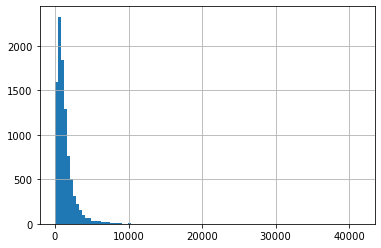

In [203]:
r10k.loc[~r10k[('price', 'std')].isna(), ('price', 'std')].hist(bins=100)